In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
#plot_n_b_psth.ipynb
#plot neural and behavior psth

import scipy.io as sio
import scipy.stats as sio_stat
import scipy.interpolate
import numpy as np
import pandas as pd
import xarray as xr
import matplotlib.pyplot as plt 

import os
import pickle
import sys
import copy

import time
import pylab as pl
from IPython import display

from bmi_dynamics_code import behavior_co_obs as bmi_b
from bmi_dynamics_code import data_for_v as preeyacode
from bmi_dynamics_code import util as bmi_util

import timeit
from sklearn import decomposition as skl_decomp

%matplotlib notebook

In [3]:
%matplotlib notebook

### Description: 
this code does the same thing that psth_polar_interp.ipynb does, except on neural push "u" which is predicted by neural dynamics

it turns out that this is problematic, because even a "zero-order hold" predictor would give a nice psth to the eye, it would just be delayed by one lag.  

For the future, we could improve this by correlating the change in psth_true_data to the change in psth_pred.  

In [13]:
# data_dir = '/Users/vivekathalye/Dropbox/Code/preeya_co_obstacle'
save_dir = r'D:\Dropbox\BMI_co_obs_paper\data\vivek\psth'
if not os.path.exists(save_dir):
    os.makedirs(save_dir)

home_dir = r'D:\Dropbox\Code\preeya_co_obstacle'
data_dir = r'D:\Dropbox\Data\preeya_co_obstacle'
data_path = os.path.join(data_dir, 'for_v_df.pkl')
print(os.path.exists(data_path))
d = pickle.load(open(data_path))

#UNPACK: 
decoder = d['decoder']
pre = d['pre']
num_targets = d['num_targets']
sample_period = d['sample_period']
target_hold_time = d['target_hold_time']
num_neurons = d['num_neurons']
target_color = d['target_color']
obs_big = d['obs_big']
obs_small = d['obs_small']
target_r_task = d['target_r_task']
cursor_r = d['cursor_r']
target_r_eff = d['target_r_eff']
target_pos = d['target_pos']
target_angle = np.arctan2(target_pos[:,1], target_pos[:,0])
target_dist = np.linalg.norm(target_pos, axis=1)
obs_pos = d['obs_pos']

tc_meta = d['tc_meta']
task_list = d['task_list']
num_tasks = len(task_list)
task2idx = d['task2idx']
idx2task = bmi_util.invert_dic(task2idx)
task2tc = d['task2tc']
tc_list = d['tc_list']
df_o = d['df']
df_label = d['df_label']

task_color = ['k', 'r']

True


In [5]:
plot_target = True
plot_obs_big = True
plot_obs_small = False

In [6]:
from sklearn.linear_model import LinearRegression

In [16]:
n_label = ['n_'+str(i) for i in range(num_neurons)]
n = df_o.loc[:, n_label]
# n_0 = df_o.loc[df_o['task']==0, n_label]
# # n_0.head()

# n_1 = df_o.loc[df_o['task']==1, n_label]
# # n_1.head()

In [18]:
#Predict one ahead: 
reg = LinearRegression().fit(n[:-1], n[1:])
#Predict next step
reg.score(n[:-1],n[1:])

0.22249763565445696

In [20]:
#Next, predict one step ahead.  
n_pred = reg.predict(n[:-1])

F_hat close to F
K_hat close to K


<IPython.core.display.Javascript object>


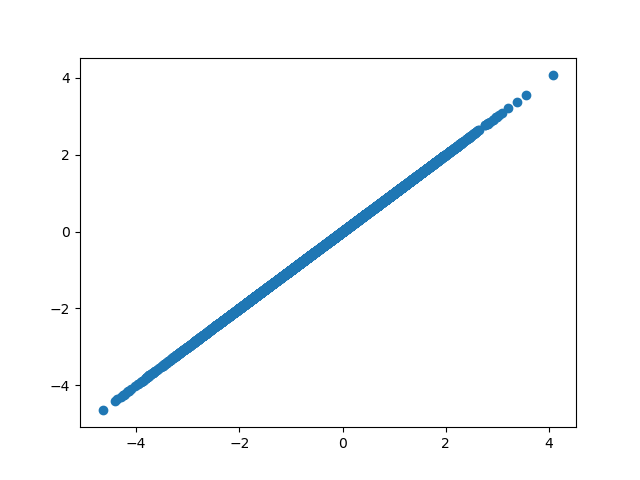

<IPython.core.display.Javascript object>


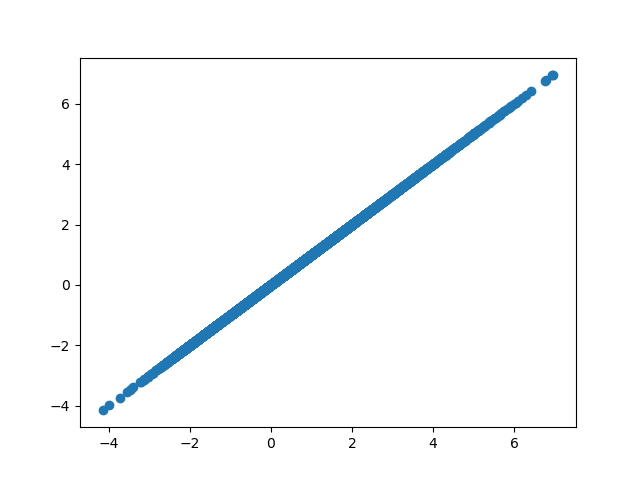

In [23]:
#Next, produce predicted u_v:
#0) get decoder
ddec=bmi_util.decompose_decoder(decoder['F'], decoder['K'])
n2u =ddec['K_d']['v'][ddec['var_idxs']['v'],:]
# plt.figure()
# plt.imshow(n2u)

#1) verify it reproduces saved data
u_hat = np.dot(n,n2u.T)
plt.figure()
plt.scatter(u_hat[:,0], df_o['u_vx'])
plt.figure()
plt.scatter(u_hat[:,1], df_o['u_vy'])

#2) predict u:
u_pred = np.dot(n_pred,n2u.T)

In [25]:
u_pred.shape

(14717L, 2L)

<IPython.core.display.Javascript object>


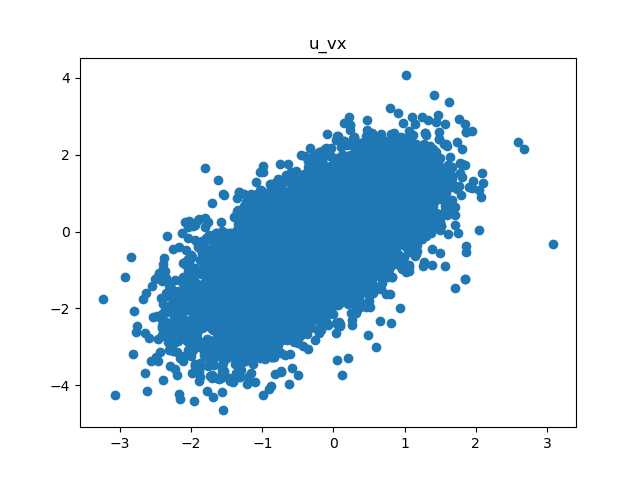

('R2:', 0.46061272701037914, 'p:', 0.0)


<IPython.core.display.Javascript object>


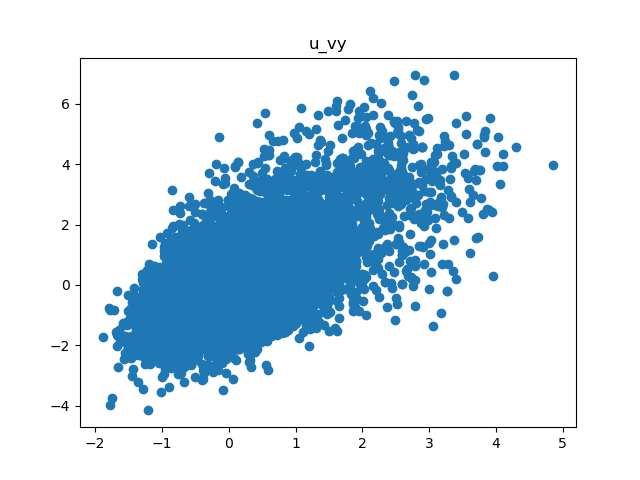

('R2:', 0.3919360684314172, 'p:', 0.0)


In [44]:
df = df_o.copy()
df.loc[1:,'u_vx'] = u_pred[:,0]
df.loc[1:,'u_vy'] = u_pred[:,1]

#Verify substitution
plt.figure()
plt.scatter(df['u_vx'], df_o['u_vx'])
plt.title('u_vx')

r,p = sio_stat.pearsonr(df['u_vx'],df_o['u_vx'])
print('R2:', r**2, 'p:', p)

plt.figure()
plt.scatter(df['u_vy'], df_o['u_vy'])
plt.title('u_vy')

r,p = sio_stat.pearsonr(df['u_vy'],df_o['u_vy'])
print('R2:', r**2, 'p:', p)

In [32]:
# 1) Convert stuff to polar, 2) center angles at target angle, 3) calculate distance to target
# 1) Convert stuff to polar
df['u_v_mag'], df['u_v_angle'] = bmi_b.cartesian2polar(df['u_vy'], df['u_vx'])
# 2) Center @ target angle: 
d_list = ['u_v_angle']
for d in d_list:
    data = df[d]
    zeros = np.zeros(data.shape)
    t_angle = target_angle[df['target'].astype(int)]
    df[d+'_ctr'] = bmi_b.center_angle(df[d], zeros, t_angle)
# 3) distance to target
error = df.loc[:, 'kin_px':'kin_py']-target_pos[df['target'].astype(int),:]
df['d2target'] = np.linalg.norm(error,ord=2,axis=1)
df['x_error'] = error.loc[:,'kin_px']
df['y_error'] = error.loc[:,'kin_py']


In [33]:
#INTERPOLATED PSTH:
#TRIALS GO FROM START TO TIME CURSOR HITS TARGET BOUNDARY
#FORM: xarray for variable x time x trial: 

#(1.7 - 0.4 = 1.3 for CO, and 2.0 - 0.5 = 1.5 for OBS).
target_r_eff = {0:1.3, 1:1.5}
num_var = df.shape[1]
num_interp_pts = 100
time_win = np.array([0, num_interp_pts])
num_time = np.diff(time_win)[0]
da_dic = {}
for task_str in task_list:
    task = task2idx[task_str]
    for target in range(num_targets):
        #------------------------------------------------------------------------------------
        #TRIALS: 
        trial_start = np.where((df['trial_start']==1) & (df['target']==target) & (df['task']==task))[0]
        trial_stop = np.where((df['trial_stop']==1) & (df['target']==target) & (df['task']==task))[0]
        trial_bound = np.vstack((trial_start,trial_stop)).T
        num_trials = trial_bound.shape[0]
        #------------------------------------------------------------------------------------
        #Initialize a nan-filled xarray
        nan_mat = np.ones((num_var, num_time, num_trials))*np.nan
        da = xr.DataArray(nan_mat,
                    coords={'var':list(df.columns),
                                     'time':range(num_time),
                                     'trial':range(num_trials)},
                    dims=['var','time','trial'])
        for trial, bnd in enumerate(trial_bound): #trial_bound[0:1,:]:
            d2target = df.loc[bnd[0]:bnd[1],'d2target']
            end = bnd[0]+np.where(d2target <= target_r_eff[task])[0][0]
            trial_len = end-bnd[0]+1
            #Linearly interpolate the trial: 
            d_trial = np.array(df.loc[bnd[0]:end,:])
            x = np.arange(0,trial_len)
            f = scipy.interpolate.interp1d(x,d_trial,axis=0)
            x_interp = np.linspace(x[0],x[-1],num_interp_pts)
            d_interp = f(x_interp).T
            da[:,:,trial] = d_interp
        da_dic[(task,target)] = da      

In [35]:
#CALCULATE PSTH:
psth_dic = {}
for task in range(num_tasks):
    for target in range(num_targets):
        mean = da_dic[task,target].mean(axis=2,skipna=True)
        N = np.logical_not(np.isnan(da_dic[task,target])).sum(axis=2) #number of data points per sample
        var = da_dic[task,target].var(axis=2,skipna=True)
        sem = (var/N)**(0.5)
        
        psth_dic[task,target,'mean'] = mean
        psth_dic[task,target,'N'] = N
        psth_dic[task,target,'var'] = var
        psth_dic[task,target,'sem'] = sem

In [36]:
# Average mag, abs angle
ctrl_psth = {}
d_list = ['u_v_mag', 'u_v_angle_ctr']
num_orient_samples = 50
for task in range(num_tasks):
    for d in d_list:
        d_mat = np.zeros((num_targets, num_time))
        d_mat = np.ma.array(d_mat)
        for target in range(num_targets):
            mean = psth_dic[task,target,'mean'].loc[d]
            #ctrl_psth[task,target,d,'mean']
            if 'angle' in d: 
                if np.sum(mean[:num_orient_samples]) > 0:
                    mean = -mean
                #want the absolute angle                
            d_mat[target,:] = mean
        #PSTH:         
#         mean = d_mat.mean(axis=0)
#         N = np.logical_not(np.isnan(d_mat)).sum(axis=0)
#         var = data.var(axis=1)
#         sem = (var/N)**(0.5)        
        ctrl_psth[task,d,'mat'] = d_mat
        ctrl_psth[task,d,'mean'] = d_mat.mean(axis=0)
        ctrl_psth[task,d,'var'] = d_mat.var(axis=0)
        ctrl_psth[task,d,'sem'] = sio_stat.sem(d_mat, axis=0, nan_policy='omit')

In [37]:
#Exclude a target:
task = 1
for d in d_list: 
    d_mat = ctrl_psth[task,d,'mat'][[0,1,2,3,5,6,7],:]
    ctrl_psth[task,d,'mean'] = d_mat.mean(axis=0)
    ctrl_psth[task,d,'var'] = d_mat.var(axis=0)
    ctrl_psth[task,d,'sem'] = sio_stat.sem(d_mat, axis=0, nan_policy='omit')    

<IPython.core.display.Javascript object>


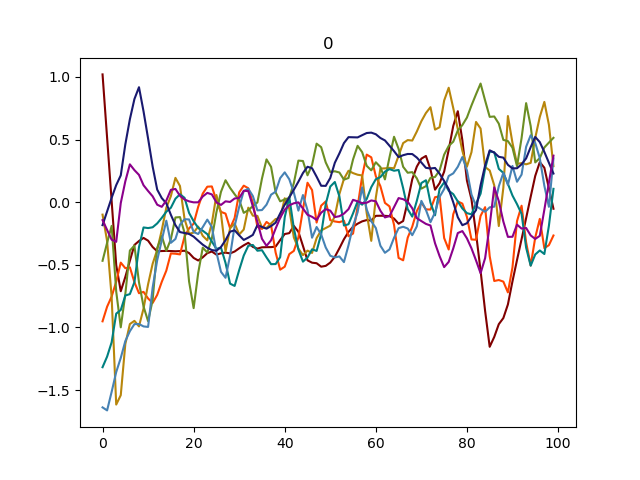

<IPython.core.display.Javascript object>


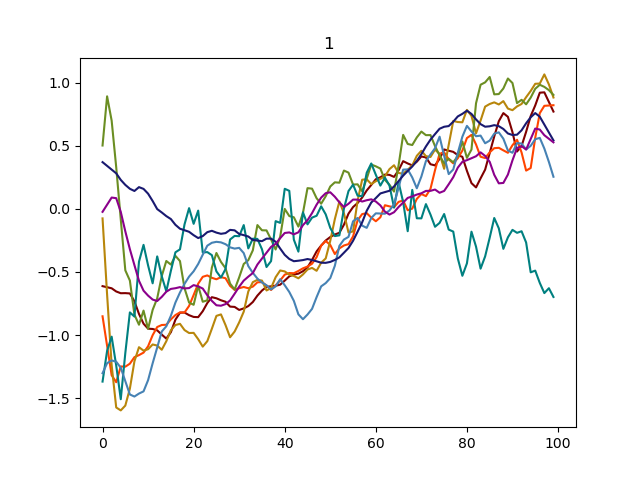

In [38]:
d_list = ['u_v_angle_ctr']
for task in range(num_tasks):
    plt.figure()
    for d in d_list:
        y_mat = ctrl_psth[task,d,'mat']
        for target in range(num_targets):
            plt.plot(y_mat[target,:], color=target_color[target])
    plt.title(task)

In [42]:
x_sol = 13*(39831)**(0.5)/2000.0
y_sol = 19831.0/2000.0
theta_max = np.arctan2(x_sol, y_sol)
print('angle to enter co target straight on:')
print(theta_max*180/np.pi)

obs_x = obs_big/2.0
obs_y = 5-obs_big/2.0
obs_theta = np.arctan2(obs_x, obs_y)
print('angle to avoid obstacle:')
print(obs_theta*180/np.pi)

angle to enter co target straight on:
7.453706284964303
angle to avoid obstacle:
23.19859051364819


<IPython.core.display.Javascript object>


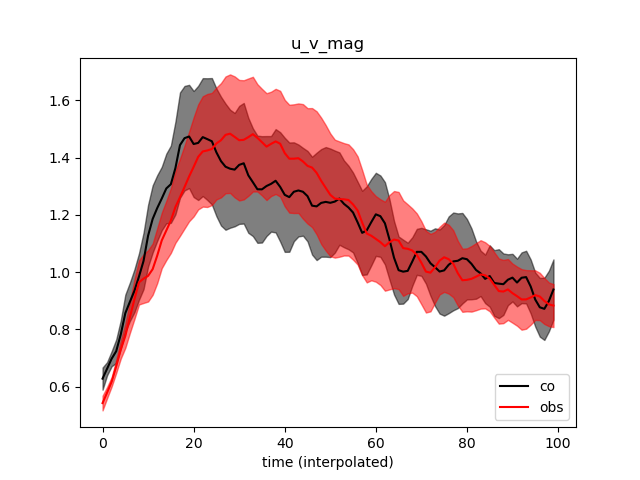

<IPython.core.display.Javascript object>


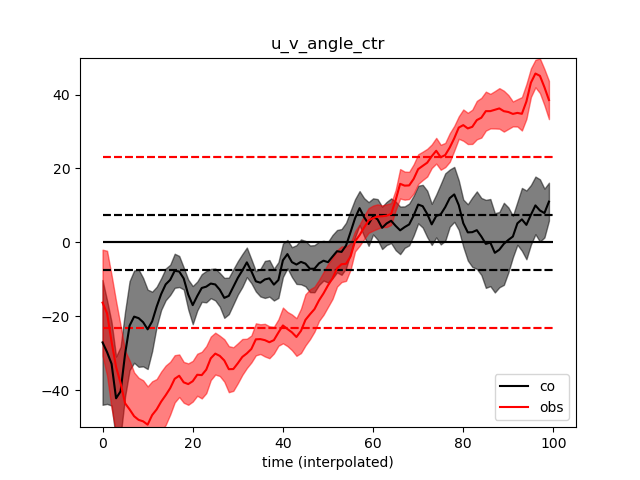

In [43]:
save_bool = False
plt_prefix = 'task_psth'
plt_ext = ['.png']

d_list = ['u_v_mag', 'u_v_angle_ctr']
plot_len = 100
for d in d_list:
    plt.figure()
    for task in range(num_tasks):
        y_mean = ctrl_psth[task,d,'mean'][:plot_len]
        y_sem = ctrl_psth[task,d,'sem'][:plot_len]
        if 'angle' in d:
            y_mean = y_mean*180/np.pi
            y_sem = y_sem*180/np.pi 
            plt.hlines(0,0,plot_len,color='k')
            plt.hlines(theta_max*180/np.pi,0,plot_len,color='k',linestyles='dashed')
            plt.hlines(-theta_max*180/np.pi,0,plot_len,color='k',linestyles='dashed')
            
            plt.hlines(obs_theta*180/np.pi,0,plot_len,color='r',linestyles='dashed')
            plt.hlines(-obs_theta*180/np.pi,0,plot_len,color='r',linestyles='dashed')            
            
            plt.legend()
        plt.plot(y_mean, color=task_color[task],label=idx2task[task])
        plt.fill_between(range(len(y_mean)), y_mean-y_sem,y_mean+y_sem,alpha=0.5,color=task_color[task])
    plt.xlabel('time (interpolated)')
    plt.title(d)
    plt.legend(loc = 'lower right')
    if 'angle' in d:
        plt.ylim(-50,50)
#         plt.axis('square')
    
        
    if save_bool: 
        plt_name = plt_prefix + '_' + d
        for ext in plt_ext:
            plt.savefig(os.path.join(save_dir, plt_name+ext))